In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import sklearn
import sklearn.metrics as skm
import sklearn.ensemble as ensemble
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# Loading data

In [2]:
file = 'data/halomi_full.tsv'
data_df = pd.read_csv(file, sep="\t")
all_metrics = ["score_log_loss","score_alti_mean","score_alti_t_mean","score_attn_ot","score_comet_qe","score_labse","score_laser","score_xnli"]
# inerse all metrics
for metric in all_metrics:
    data_df[metric] = - data_df[metric]

data_df["is_hall"] = data_df["class_hall"].apply(lambda x:1 if x[0]!='1' else 0)
data_df["is_omit"] = data_df["class_omit"].apply(lambda x:1 if x[0]!='1' else 0)

high_resource_languages = ["arb_Arab", "deu_Latn", "rus_Cyrl", "spa_Latn", "zho_Hans"]
low_resource_language_pairs = ["kas_Deva", "mni_Beng", "yor_Latn"]

data_high = data_df[
    data_df["direction"].apply(
        lambda x: any([lang in x for lang in high_resource_languages])
        and "eng_Latn" in x
    )
].copy()

data_low = data_df[
    data_df["direction"].apply(
        lambda x: any([lang in x for lang in low_resource_language_pairs])
        and "eng_Latn" in x
    )
].copy()



In [3]:
print("Non hallucinations :",len(data_high[data_high["is_hall"]==0]))
print("Hallucinations :",len(data_high[data_high["is_hall"]==1]))

print("Non omisions :",len(data_high[data_high["is_omit"]==0]))
print("Omisions :",len(data_high[data_high["is_omit"]==1]))

Non hallucinations : 1919
Hallucinations : 1010
Non omisions : 1292
Omisions : 1637


# Hallucination Detection

In [32]:

def auroc_fpr(pred, num_thresh = 100):
    thrs = np.linspace(start=pred.min(), stop=pred.max(), num=num_thresh)
    decision_by_thr = np.zeros((len(pred), num_thresh))
    
    for i in range(len(thrs)):
        thr = thrs[i]
        y_pred = np.where(pred <= thr, 1, 0)
        decision_by_thr[:, i] = y_pred
    return decision_by_thr

def calculate_auc_fp_from_pred(pred, testdata_is_hall):
    decision_by_thr = auroc_fpr(pred, num_thresh = 100)
    is_hall = np.zeros(decision_by_thr.shape)
    for i in range(is_hall.shape[1]):
        is_hall[:, i] = testdata_is_hall.to_numpy()

    tp = np.where((decision_by_thr == 1) & (is_hall==1), 1, 0)
    fn = np.where((decision_by_thr == 0) & (is_hall==1), 1, 0)
    tn = np.where((decision_by_thr == 0) & (is_hall==0), 1, 0)
    fp = np.where((decision_by_thr == 1) & (is_hall==0), 1, 0)

    tpr = tp.sum(axis=0) / (tp.sum(axis=0) + fn.sum(axis=0))
    fpr = fp.sum(axis=0) / (fp.sum(axis=0) + tn.sum(axis=0))

    x = np.interp(0.90, np.sort(tpr), np.sort(fpr))
    auc, fp = skm.auc(np.sort(fpr), np.sort(tpr)) * 100, x * 100
    return auc, fp

def calculate_auc_fp(trainset_data_detectors,testset_data_detectors,testdata_is_hall,prediction_method,num_try = 10,*args, **kwargs):
    all_auc, all_fp = 0, 0
    for _ in range(num_try):
        pred = prediction_method(trainset_data_detectors,testset_data_detectors,*args, **kwargs)
        auc, fp = calculate_auc_fp_from_pred(pred, testdata_is_hall)
        all_auc += auc
        all_fp += fp
    return all_auc / num_try, all_fp / num_try, pred

def get_best_threshold(pred, testdata_is_hall,num_thresh = 100):
    thrs = np.linspace(start=pred.min(), stop=pred.max(), num=num_thresh)
    decision_by_thr = auroc_fpr(pred, num_thresh = num_thresh)
    is_hall = np.zeros(decision_by_thr.shape)
    for i in range(is_hall.shape[1]):
        is_hall[:, i] = testdata_is_hall.to_numpy()
    f1 = np.zeros(decision_by_thr.shape[1])
    for i in range(is_hall.shape[1]):
        f1[i] = skm.f1_score(is_hall[:, i], decision_by_thr[:, i])
    return thrs[np.argmax(f1)], f1.max()

def plot_prediction(pred, testdata_is_hall, title, thr,nbins=50):
    plt.figure(figsize=(10, 6))
    bins = np.histogram(pred, bins=nbins)[1]
    
    sns.histplot(pred[testdata_is_hall == 0], bins=bins, color='green', label="No Hallucination", kde=True, edgecolor='white')
    sns.histplot(pred[testdata_is_hall == 1], bins=bins, color='red', label="Hallucination", kde=True, edgecolor='white')
    plt.axvline(x=thr, color='black', linestyle='--', linewidth=2, label='Threshold')
    
    plt.xlabel('Prediction Values')
    plt.ylabel('Frequency')
    plt.title(title, fontsize=16)
    sns.set_palette("Set2")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    sns.despine()
    
    plt.show()

## Prediction Methods

In [5]:
def prediction_method_single(trainset_data_detectors,testset_data_detectors): # single detector
    pred = testset_data_detectors
    return pred

In [6]:
def prediction_method_IF(trainset_data_detectors,testset_data_detectors): # aggregation of detectors using isolation forest
    isolation_forest = ensemble.IsolationForest(n_estimators=500,n_jobs=-1)
    clf = isolation_forest.fit(trainset_data_detectors)
    pred = clf.score_samples(testset_data_detectors)
    return pred

In [7]:
from sklearn.linear_model import LogisticRegression
def prediction_logistic_regression(trainset_data_detectors,testset_data_detectors,trainset_data_is_hall):
    logistic_regression = LogisticRegression(max_iter=1000,solver='liblinear')
    trainset_data_is_hall = np.array(trainset_data_is_hall).ravel()
    logistic_regression.fit(trainset_data_detectors, trainset_data_is_hall)
    pred = logistic_regression.predict_proba(testset_data_detectors)[:, 1]
    return -pred

# Results

In [8]:
datasets = {"high":data_high,"low":data_low,"full":data_df}
oods = ["is_hall", "is_omit"]

In [9]:
N_dfs = 10
p = 0.1 # fraction of data to use for training
data_df_trainsets = {}
data_df_testsets = {}
for dataset in datasets:
    data_df_trainsets[dataset] = []
    data_df_testsets[dataset] = []
    for i in range(N_dfs):
        data_df_trainsets[dataset].append(datasets[dataset].sample(frac=p, random_state=i))
        data_df_testsets[dataset].append(datasets[dataset].drop(data_df_trainsets[dataset][i].index))


In [10]:
model_metrics = ["score_log_loss", "score_alti_mean", "score_attn_ot"]
external_metrics = ["score_comet_qe","score_labse","score_laser","score_xnli"]
model_external_metrics = model_metrics + external_metrics

metrics_type = {
    "model":model_metrics,
    "external":external_metrics,
    "all":model_external_metrics}


normalized_metrics = {}
for dataset in datasets:
    normalized_metrics[dataset] = {}
    for i in range(N_dfs):
        normalized_metrics[dataset][i] = {}
        for metric in model_external_metrics:
            normalized_metrics[dataset][i][metric] = data_df_testsets[dataset][i][metric].apply(lambda x: (x - data_df_trainsets[dataset][i][metric].min()) / (data_df_trainsets[dataset][i][metric].max() - data_df_trainsets[dataset][i][metric].min()))

In [15]:
configs = {}
for dataset in datasets:
    configs[dataset] = {}
    for i in range(N_dfs):
        data_df_testset = data_df_testsets[dataset][i]
        data_df_trainset = data_df_trainsets[dataset][i]
        configs[dataset][i] = []
        for ood in oods:
            for metric in model_external_metrics:
                config = {"ood":ood,"name":metric,"trainset_data_detectors":None,"testset_data_detectors":data_df_testset[metric],
                        "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
                        "trainset_data_is_hall":None}
                configs[dataset][i].append(config)
            # Sum_norm
            for name,metrics in metrics_type.items():
                config = {"ood":ood,"name":"Sum_norm_"+name,"trainset_data_detectors":None,
                        "testset_data_detectors":np.sum(pd.DataFrame(normalized_metrics[dataset][i])[metrics],axis=1),
                        "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
                        "trainset_data_is_hall":None}
                configs[dataset][i].append(config)
            # Max_norm
            for name,metrics in metrics_type.items():
                config = {"ood":ood,"name":"Max_norm_"+name,"trainset_data_detectors":None,
                        "testset_data_detectors":np.max(pd.DataFrame(normalized_metrics[dataset][i])[metrics],axis=1),
                        "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
                        "trainset_data_is_hall":None}
                configs[dataset][i].append(config)
            # IF
            for name,metrics in metrics_type.items():
                config = {"ood":ood,"name":"IF_"+name,"trainset_data_detectors":data_df_trainset[metrics],
                        "testset_data_detectors":data_df_testset[metrics],
                        "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_IF,"num_try":1,
                        "trainset_data_is_hall":None}
                configs[dataset][i].append(config)
            # logistic_regression
            config = {"ood":ood,"name":"logistic_regression","trainset_data_detectors":data_df_trainset[model_external_metrics],
                        "testset_data_detectors":data_df_testset[model_external_metrics],
                        "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_logistic_regression,"num_try":1,
                        "trainset_data_is_hall":data_df_trainset[ood]}
            configs[dataset][i].append(config)

In [22]:
results_full = {}
for dataset in datasets:
    results_full[dataset] = {}
    for config in configs[dataset][0]:
        if config["ood"] not in results_full[dataset]:
            results_full[dataset][config["ood"]] = {}
        results_full[dataset][config["ood"]][config["name"]] = []

In [23]:
for dataset in tqdm(datasets):
    for i in trange(N_dfs):
        for config in configs[dataset][i]:
            if len(results_full[dataset][config["ood"]][config["name"]]) < i+1:
                if config["trainset_data_is_hall"] is None:
                    auc, fp, pred = calculate_auc_fp(config["trainset_data_detectors"],config["testset_data_detectors"], config["testdata_is_hall"], 
                                                config["prediction_method"], num_try = config["num_try"])
                else:
                    auc, fp, pred = calculate_auc_fp(config["trainset_data_detectors"],config["testset_data_detectors"], config["testdata_is_hall"], 
                                                config["prediction_method"], num_try = config["num_try"],
                                                trainset_data_is_hall =config["trainset_data_is_hall"])
                thr, f1 = get_best_threshold(pred, config["testdata_is_hall"])
                results_full[dataset][config["ood"]][config["name"]].append({"auc":auc,"fp":fp, "f1_score":f1, "pred":pred, "thr":thr})


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


high is_hall

high is_omit


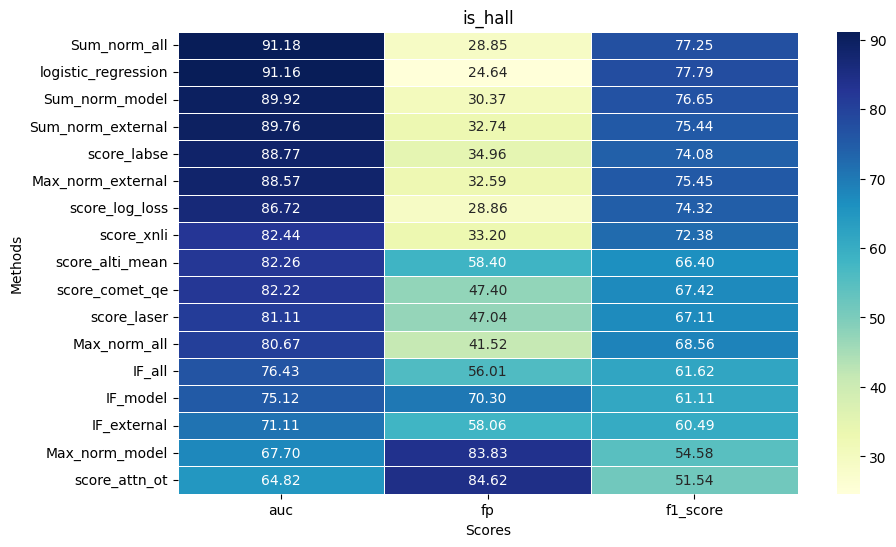

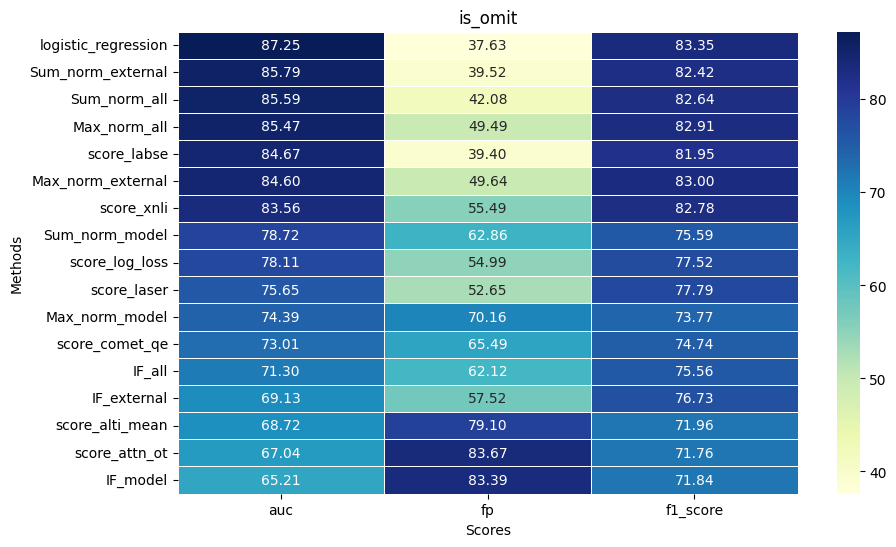

In [44]:
for dataset in ["high"]:
    for ood in results_full[dataset]:
        print("\n"+dataset+" "+ood)
        results_full_df = pd.DataFrame(columns=["method", "auc", "fp", "f1_score"])

        for metric in results_full[dataset][ood]:
            results_full_df = results_full_df.append({
                "method": metric,
                "auc": np.mean([results_full[dataset][ood][metric][i]["auc"] for i in range(N_dfs)]),
                "fp": np.mean([results_full[dataset][ood][metric][i]["fp"] for i in range(N_dfs)]),
                "f1_score": 100*np.mean([results_full[dataset][ood][metric][i]["f1_score"] for i in range(N_dfs)])
            }, ignore_index=True)

        # sort by auc
        results_full_df.sort_values(by=['auc'],ascending=False,inplace=True)
        results_full_df = results_full_df.set_index('method')
        results_full_df = results_full_df.astype(float)
        

        plt.figure(figsize=(10, 6))  # Set a larger figure size for better visibility
        sns.heatmap(results_full_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
        plt.xlabel('Scores')
        plt.ylabel('Methods')
        plt.title(ood)
        plt.plot()

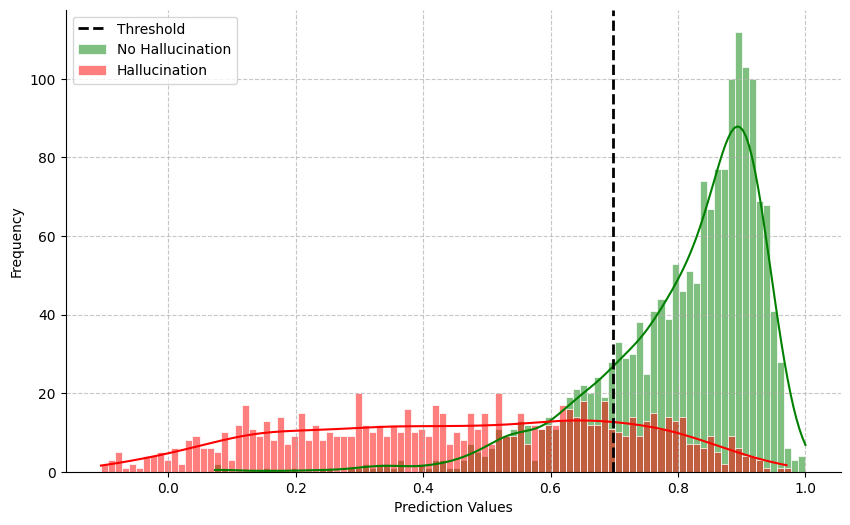

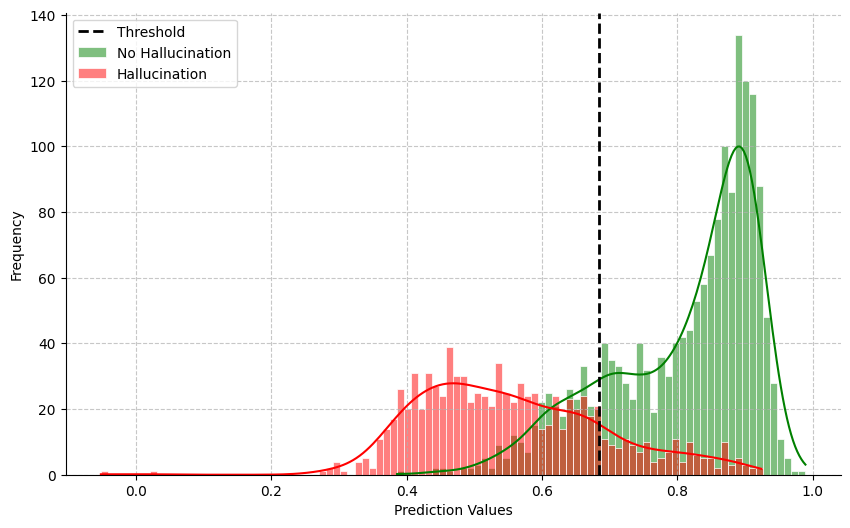

In [45]:
m_to_plot = "score_labse"
ood = "is_hall"
dataset = "high"
i=0
plot_prediction(results_full[dataset][ood][m_to_plot][i]["pred"],data_df_testsets[dataset][i]['is_hall'].values,"",results_full[dataset][ood][m_to_plot][i]["thr"],nbins=100)
m_to_plot = "Sum_norm_all"
plot_prediction(results_full[dataset][ood][m_to_plot][i]["pred"]/len(model_external_metrics),data_df_testsets[dataset][i]['is_hall'].values,"",results_full[dataset][ood][m_to_plot][i]["thr"]/len(model_external_metrics),nbins=100)


In [36]:
print(external_metrics)
print(model_metrics)

['score_comet_qe', 'score_labse', 'score_laser', 'score_xnli']
['score_log_loss', 'score_alti_mean', 'score_attn_ot']


In [43]:
for dataset in ["high"]:
    for ood in results_full[dataset]:
        results_full_df = pd.DataFrame(columns=["method", "auc", "fp", "f1_score"])

        for metric in results_full[dataset][ood]:
            results_full_df = results_full_df.append({
                "method": metric,
                "auc": results_full[dataset][ood][metric][0]["auc"],
                "fp": results_full[dataset][ood][metric][0]["fp"],
                "f1_score": 100*results_full[dataset][ood][metric][0]["f1_score"],
            }, ignore_index=True)

        # sort by auc
        results_full_df.sort_values(by=['auc'],ascending=False,inplace=True)
        results_full_df = results_full_df.set_index('method')
        results_full_df = results_full_df.astype(float)

        print("\\begin{table}[t]")
        print("\\centering")
        print("\\renewcommand\\arraystretch{1}")
        print("\\footnotesize")
        print("\\begin{tabular}{>{\\arraybackslash}m{2.45cm} r r}")
        print("\\toprule")
        print("\\textsc{Detector} & AUROC $\\uparrow$ & FPR@90TPR $\\uparrow$\\\\")
        print("\\midrule \\midrule")
        print("\\multicolumn{3}{c}{{\\textit{Individual Detectors}}} \\\\\\midrule")
        print("\\multicolumn{3}{l}{{\\textit{External}}} \\\\")

        external_detectors = {m.replace('_','\_'):m for m in external_metrics}
        for detector, key in external_detectors.items():
            auc = results_full_df.loc[key]["auc"]
            fpr = results_full_df.loc[key]["fp"]
            print(f"{detector} & {auc:.2f} & {fpr:.2f} \\\\")

        print("\\cdashlinelr{1-3}\\noalign{\\vskip 0.5ex}")
        print("\\multicolumn{3}{l}{{\\textit{Model-based}}} \\\\")

        model_detectors = {m.replace('_','\_'):m for m in model_metrics}
        for detector, key in model_detectors.items():
            auc = results_full_df.loc[key]["auc"]
            fpr = results_full_df.loc[key]["fp"]
            print(f"{detector} & {auc:.2f} & {fpr:.2f} \\\\")

        print("\\midrule\\midrule")
        print("\\multicolumn{3}{c}{{\\textit{Aggregated Detectors}}} \\\\\\midrule")
        print("\\multicolumn{3}{l}{{\\textit{External Only}}} \\\\")

        external_aggregated_detectors = {"Isolation Forest":"IF_external", "Max-Norm":"Max_norm_external", "Sum-Norm":"Sum_norm_external"}
        for detector, key in external_aggregated_detectors.items():
            auc = results_full_df.loc[key]["auc"]
            fpr = results_full_df.loc[key]["fp"]
            print(f"{detector} & {auc:.2f} & {fpr:.2f} \\\\")

        print("\\cdashlinelr{1-3}\\noalign{\\vskip 0.5ex}")
        print("\\multicolumn{3}{l}{{\\textit{Model-based Only}}} \\\\")

        model_aggregated_detectors = {"Isolation Forest":"IF_model", "Max-Norm":"Max_norm_model", "Sum-Norm":"Sum_norm_model"}
        for detector, key in model_aggregated_detectors.items():
            auc = results_full_df.loc[key]["auc"]
            fpr = results_full_df.loc[key]["fp"]
            print(f"{detector} & {auc:.2f} & {fpr:.2f} \\\\")

        print("\\cdashlinelr{1-3}\\noalign{\\vskip 0.5ex}")
        print("\\multicolumn{3}{l}{{\\textit{All}}} \\\\")

        all_aggregated_detectors = {"Isolation Forest":"IF_all", "Max-Norm":"Max_norm_all", "Sum-Norm":"Sum_norm_all"}
        for detector, key in all_aggregated_detectors.items():
            auc = results_full_df.loc[key]["auc"]
            fpr = results_full_df.loc[key]["fp"]
            print(f"{detector} & {auc:.2f} & {fpr:.2f} \\\\")

        print("\\bottomrule")
        print("\\end{tabular}")
        print("\\caption{"+dataset+ " Halomi " +ood.replace('_','\_')+"}")
        print("\\label{tab:auroc_fpr_all}")
        print("\\end{table}")


\begin{table}[t]
\centering
\renewcommand\arraystretch{1}
\footnotesize
\begin{tabular}{>{\arraybackslash}m{2.45cm} r r}
\toprule
\textsc{Detector} & AUROC $\uparrow$ & FPR@90TPR $\uparrow$\\
\midrule \midrule
\multicolumn{3}{c}{{\textit{Individual Detectors}}} \\\midrule
\multicolumn{3}{l}{{\textit{External}}} \\
score\_comet\_qe & 82.71 & 46.13 \\
score\_labse & 88.96 & 34.92 \\
score\_laser & 81.12 & 46.81 \\
score\_xnli & 82.90 & 32.64 \\
\cdashlinelr{1-3}\noalign{\vskip 0.5ex}
\multicolumn{3}{l}{{\textit{Model-based}}} \\
score\_log\_loss & 86.58 & 28.37 \\
score\_alti\_mean & 82.18 & 58.76 \\
score\_attn\_ot & 64.95 & 84.66 \\
\midrule\midrule
\multicolumn{3}{c}{{\textit{Aggregated Detectors}}} \\\midrule
\multicolumn{3}{l}{{\textit{External Only}}} \\
Isolation Forest & 68.06 & 69.09 \\
Max-Norm & 89.25 & 32.10 \\
Sum-Norm & 89.89 & 32.58 \\
\cdashlinelr{1-3}\noalign{\vskip 0.5ex}
\multicolumn{3}{l}{{\textit{Model-based Only}}} \\
Isolation Forest & 72.18 & 76.33 \\
Max-Norm & 6